# Some Synthetic Experiments
This notebook implement the uncertainty quantification method from the paper "Inference and uncertainty quantification for noisy matrix completion" https://arxiv.org/abs/2107.12365


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../cmc')

In [2]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import logging

#### The functions created for our project

In [3]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from inference_function import *   # constructing the confidence intervals using the algorithm from the paper

## Data generation using our functions

Sampling from the noisy random orthogonal model... 



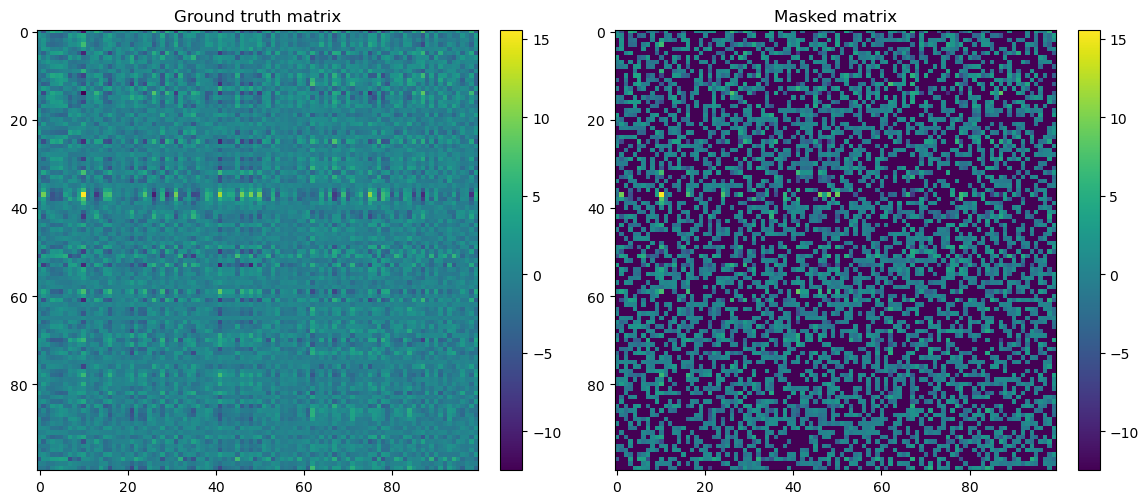

In [25]:
# Define experiment parameters
m, n, r = 100,100, 5
prob_obs = 0.5
random_state = 1
sigma = 0.001  #noise level

# Generate missing samples
sampler = RandomSampling(m, n)
mask = sampler.sample_observed(prop = prob_obs, fix_size = False, random_state=random_state)

# print('Sampling from the noiseless random factorization model... \n')
# RFM = RandomFactorizationModel(m ,n, r)
# _, _ ,M_rfm = RFM.sample_noiseless(random_state)

# masked_M_rfm = mask * M_rfm
# vmin, vmax = np.min(M_rfm), np.max(M_rfm)
# plot_before_after_mask(M_rfm, mask, vmin, vmax)

# print('\n'+'='*70+'\n')

# print('Sampling from the noiseless random orthogonal model... \n')
# ROM = RandomOrthogonalModel(m ,n, r)
# _,_,M_rom = ROM.sample_noiseless(random_state)

# masked_M_rom = mask * M_rom
# vmin, vmax = np.min(M_rom), np.max(M_rom)
# plot_before_after_mask(M_rom, mask, vmin, vmax)

# print('\n'+'='*70+'\n')

print('Sampling from the noisy random orthogonal model... \n')
ROM = RandomOrthogonalModel(m ,n, r)
_,_,_,_, M_rom_noisy = ROM.sample_noisy(random_state= random_state, sigma=sigma)

masked_M_rom = mask * M_rom_noisy
vmin, vmax = np.min(M_rom_noisy), np.max(M_rom_noisy)
plot_before_after_mask(M_rom_noisy, mask, vmin, vmax)

## Data generation in original paper

In [5]:
# Data generating functions
def generate_fixed_matrix(n1, n2, r, kappa=1):
    U_truth = orth(np.random.randn(n1, r))
    V_truth = orth(np.random.randn(n2, r))
    S_truth = np.diag(np.linspace(1, kappa, r))
    M = U_truth @ S_truth @ V_truth.T
    M = M / np.std(M)
    return M

def generate_noise(n1, n2, sigma, df="inf"):
    if df=="inf":
        E = np.random.normal(0, sigma, (n1, n2))
    else:
        E = sigma * np.random.standard_t(df, (n1, n2))
    return E

# Data generation
n1 = 100
n2 = 100
r = 5
p = 0.4
sigma = 1
kappa = 1
np.random.seed(1)



M = generate_fixed_matrix(n1, n2, r, kappa=kappa)  # M is rescaled with std(M)=1
E = generate_noise(n1, n2, sigma)

A = (np.random.rand(n1, n2) < p).astype(int)
M_obs = (M + E) * A

## Run the confidence interval constructed by the inference paper (Chen et al.)

In [6]:
alpha = 0.1

### Nonconvex method

In [7]:
CI_left, CI_right = CI_method(M_obs, A, r, alpha, method='ncvx')

# check
inside_CI = (M < CI_right) & (M > CI_left)
print(np.mean(inside_CI))  # if around (1-alpha), then good

#compute CI length
CI_length = CI_right - CI_left
print("Average CI Length:", CI_length.mean())

0.834
Average CI Length: 1.6821981694125852


### Convex Method

In [8]:
CI_left, CI_right = CI_method(M_obs, A, r, alpha, method='cvx')

# check
inside_CI = (M < CI_right) & (M > CI_left)
print(np.mean(inside_CI))  # if around (1-alpha), then good

#compute CI length
CI_length = CI_right - CI_left
print("Average CI Length:", CI_length.mean())

0.8305
Average CI Length: 1.680930255017741


# Plot the average coverage

## Experiment with fixed ground matrix and resampled masks
The ground truth noisy matrix is kept same for all repetition and the mask matrix is resampled at each iteration.

### Nonconvex method

In [9]:
# Data generation
n1 = 100
n2 = 100
r = 5
p = 0.4 #proportion of observed
sigma = 1  # noise level can be changed (orignally 1e-3)
kappa = 1
np.random.seed(1)

M = generate_fixed_matrix(n1, n2, r, kappa=kappa)
E = generate_noise(n1, n2, sigma)
M_true = M + E

In [10]:
repetition = 10
alpha = 0.1
random_state = 1

results = []

for i in tqdm(range(repetition)):
    mask = (np.random.rand(n1, n2) < p).astype(int)
    CI_left, CI_right = run_single_experiment_paper(underlying_matrix = M_true, mask=mask, r=r, alpha=alpha, 
                                                    method='ncvx')
    inside_CI = (M < CI_right) & (M > CI_left)
    result_coverage = np.mean(inside_CI)
    
    CI_length = CI_right - CI_left
    result_length = CI_length.mean()
    
    results.append({"Coverage": result_coverage, "Size": result_length})
    
results_df = pd.DataFrame(results)

100%|██████████| 10/10 [00:00<00:00, 21.71it/s]


#### Plot the average coverage and the length of confidence intervals

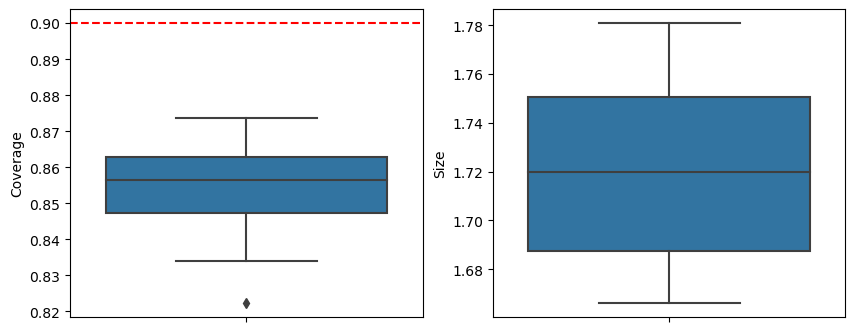

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(y="Coverage", data=results_df, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1 - alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results_df, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

## Experiments with everything resampled every iteration

### Use a different rank for matrix completion (nonconvex)

In [12]:
# Data generation
n1 = 100
n2 = 100
r_true = 5
r_guess = 4
p = 0.4 #proportion of observed
sigma = 0.001
kappa = 1

In [13]:
#nonconvex method
repetition = 100
alpha = 0.1
random_state = 42

results = []

for i in tqdm(range(repetition)):
    #regenerate the underlying matrix
    M = generate_fixed_matrix(n1, n2, r_true, kappa=kappa)
    #regenerate the noise matrix
    E = generate_noise(n1, n2, sigma)
    # regenerate mask
    A = (np.random.rand(n1, n2) < p).astype(int)
    
    M_true = M + E
    
    # run the inference algorithm
    CI_left, CI_right = run_single_experiment_paper(underlying_matrix = M_true, mask=A, r=r_guess, alpha=alpha, method='ncvx')
    inside_CI = (M < CI_right) & (M > CI_left)
    result_coverage = np.mean(inside_CI)
    
    CI_length = CI_right - CI_left
    result_length = CI_length.mean()
    
    results.append({"Coverage": result_coverage, "Size": result_length})
    
results_df = pd.DataFrame(results)

100%|██████████| 100/100 [00:05<00:00, 16.83it/s]


In [14]:
# Convex method
results = []

for i in tqdm(range(repetition)):
    #regenerate the underlying matrix
    M = generate_fixed_matrix(n1, n2, r_true, kappa=kappa)
    #regenerate the noise matrix
    E = generate_noise(n1, n2, sigma)
    # regenerate mask
    A = (np.random.rand(n1, n2) < p).astype(int)
    
    M_true = M + E
    
    # run the inference algorithm
    CI_left, CI_right = run_single_experiment_paper(underlying_matrix = M_true, mask=A, r=r_guess, alpha=alpha, method='cvx')
    inside_CI = (M < CI_right) & (M > CI_left)
    result_coverage = np.mean(inside_CI)
    
    CI_length = CI_right - CI_left
    result_length = CI_length.mean()
    
    results.append({"Coverage": result_coverage, "Size": result_length})
    
results_df_cvx = pd.DataFrame(results)

100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


Nonconvex


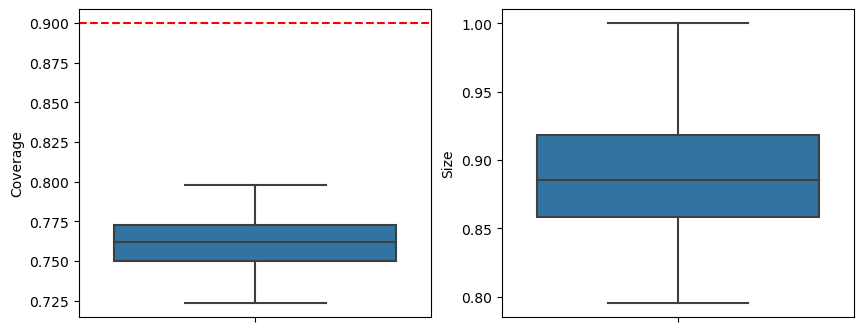



Convex


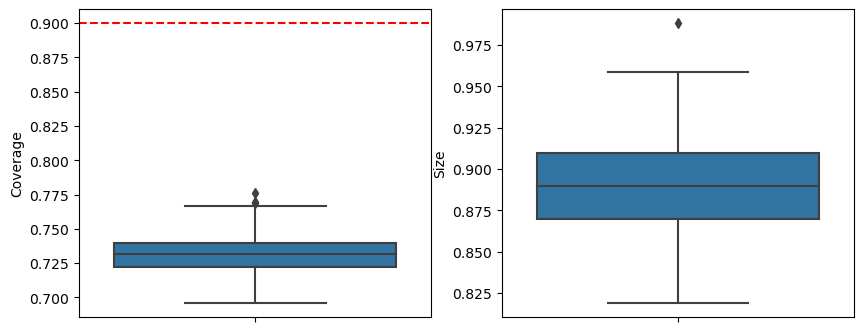

In [15]:
print('Nonconvex')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(y="Coverage", data=results_df, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1 - alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results_df, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

print('\n'+'='*70+'\n')
print('Convex')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(y="Coverage", data=results_df_cvx, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1 - alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results_df_cvx, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

# Experiments with varying matrix sizes

In [16]:
# Fixed parameters
r_true = 5
r_guess = 5
p = 0.5        #proportion of observed
sigma = 1
kappa = 1
alpha = 0.1

# Varying parameters
n_list = [100,200,300]

def run_experiment(n, seed, method = 'ncvx'):
    # default method is nonconvex
    # Parameters for this experiment
    n1 = n
    n2 = n
    
    #regenerate the underlying matrix
    M = generate_fixed_matrix(n1, n2, r_true, kappa=kappa)
    #regenerate the noise matrix
    E = generate_noise(n1, n2, sigma)
    M_true = M + E

    # regenerate mask
    A = (np.random.rand(n1, n2) < p).astype(int)    
    
    # run the inference algorithm
    CI_left, CI_right = run_single_experiment_paper(underlying_matrix = M_true, mask=A, r=r_guess, alpha=alpha, 
                                                    method=method)
    inside_CI = (M < CI_right) & (M > CI_left)
    result_coverage = np.mean(inside_CI)
    
    CI_length = CI_right - CI_left
    result_length = CI_length.mean()
    
    res = pd.DataFrame({"n":[n], "Seed":[seed], "Coverage": [result_coverage], "Size": [result_length]})
    return res

repetition = 10
results = pd.DataFrame({})
for seed in tqdm(range(repetition)):
    for n in n_list:
        res_new = run_experiment(n, seed, method = 'cvx')
        results = pd.concat([results, res_new])

100%|██████████| 10/10 [00:00<00:00, 10.04it/s]


In [17]:
summary = results.groupby(['n']).agg({'Seed':['count'],'Coverage':[np.mean,np.std], 'Size':[np.mean,np.std]}).reset_index()
summary

n  Seed  Coverage                Size          
       count      mean       std      mean       std
0  100    10  0.848060  0.009652  1.442049  0.022408
1  200    10  0.867465  0.004357  1.003189  0.005365
2  300    10  0.877639  0.005707  0.823680  0.001902

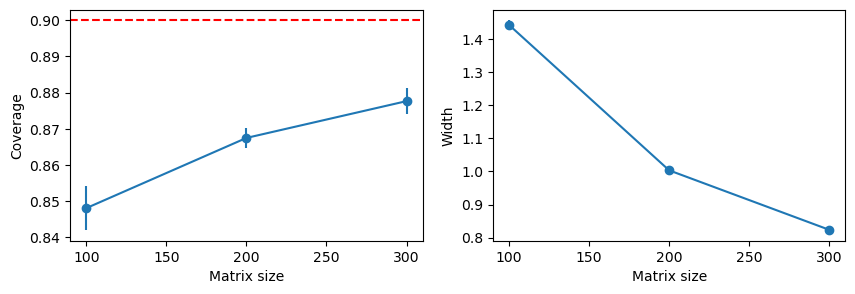

In [18]:
plt.rcParams["figure.figsize"] = (10,3)

plt.subplot(1, 2, 1)
plt.scatter(summary["n"], summary["Coverage"]["mean"])
plt.errorbar(summary["n"], summary["Coverage"]["mean"], 2*summary["Coverage"]["std"]/np.sqrt(summary["Seed"]["count"]))
plt.axhline(y=1-alpha, color='r', linestyle='--')
plt.xlabel("Matrix size")
plt.ylabel("Coverage")

plt.subplot(1, 2, 2)
plt.scatter(summary["n"], summary["Size"]["mean"])
plt.errorbar(summary["n"], summary["Size"]["mean"], 2*summary["Size"]["std"]/np.sqrt(summary["Seed"]["count"]))
plt.xlabel("Matrix size")
plt.ylabel("Width")

plt.show()

# Experiments with non-Gaussian noise (heavy tail)

In [19]:
# Fixed parameters
r_true = 5
r_guess = 5
p = 0.5        #proportion of observed
sigma = 1
kappa = 1
alpha = 0.1

# Varying parameters
n_list = [100]
df_list = [2,3,4,5,10]

def run_experiment(n, df, seed, method = 'ncvx'):
    # Parameters for this experiment
    n1 = n
    n2 = n
    
    #regenerate the underlying matrix
    M = generate_fixed_matrix(n1, n2, r_true, kappa=kappa)
    #regenerate the noise matrix
    E = generate_noise(n1, n2, sigma, df=df)
    M_true = M + E

    # regenerate mask
    A = (np.random.rand(n1, n2) < p).astype(int)    
    
    # run the inference algorithm
    CI_left, CI_right = run_single_experiment_paper(underlying_matrix = M_true, mask=A, r=r_guess, alpha=alpha, 
                                                    method = method)
    inside_CI = (M < CI_right) & (M > CI_left)
    result_coverage = np.mean(inside_CI)
    
    CI_length = CI_right - CI_left
    result_length = CI_length.mean()
    
    res = pd.DataFrame({"n":[n], "df":[df], "Seed":[seed], "Coverage": [result_coverage], "Size": [result_length]})
    return res

repetition = 100
results = pd.DataFrame({})
for seed in tqdm(range(repetition)):
    for n in n_list:
        for df in df_list:
            res_new = run_experiment(n, df, seed, method = 'cvx')
            results = pd.concat([results, res_new])

100%|██████████| 100/100 [00:32<00:00,  3.09it/s]


In [20]:
summary = results.groupby(['n','df']).agg({'Seed':['count'],'Coverage':[np.mean,np.std], 'Size':[np.mean,np.std]}).reset_index()
summary

n  df  Seed  Coverage                Size          
           count      mean       std      mean       std
0  100   2   100  0.699165  0.078828  3.893615  2.398838
1  100   3   100  0.781854  0.033883  2.319869  0.140055
2  100   4   100  0.812844  0.012544  1.949884  0.089043
3  100   5   100  0.821602  0.013016  1.782323  0.040008
4  100  10   100  0.835917  0.010110  1.575884  0.020125

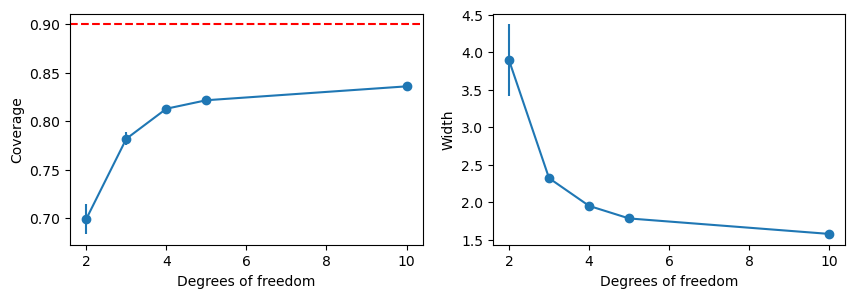

In [21]:
summary = summary[summary['n'] == 100] 

plt.rcParams["figure.figsize"] = (10,3)

plt.subplot(1, 2, 1)
plt.scatter(summary["df"], summary["Coverage"]["mean"])
plt.errorbar(summary["df"], summary["Coverage"]["mean"], 2*summary["Coverage"]["std"]/np.sqrt(summary["Seed"]["count"]))
plt.axhline(y=1-alpha, color='r', linestyle='--')
plt.xlabel("Degrees of freedom")
plt.ylabel("Coverage")

plt.subplot(1, 2, 2)
plt.scatter(summary["df"], summary["Size"]["mean"])
plt.errorbar(summary["df"], summary["Size"]["mean"], 2*summary["Size"]["std"]/np.sqrt(summary["Seed"]["count"]))
plt.xlabel("Degrees of freedom")
plt.ylabel("Width")

plt.show()

## Implementing with our data generating functions

Sampling from the noisy random orthogonal model... 



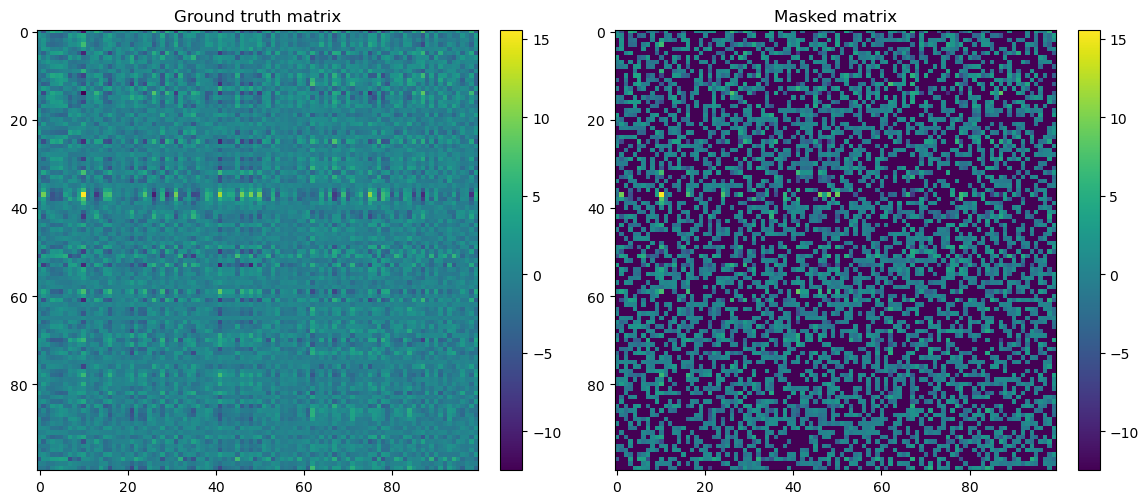

In [25]:
# Define experiment parameters
m, n, r = 100,100, 5
prob_obs = 0.5
random_state = 1
sigma = 0.001  #noise level

# Generate missing samples
sampler = RandomSampling(m, n)
mask = sampler.sample_observed(prop = prob_obs, fix_size = False, random_state=random_state)

# print('Sampling from the noiseless random factorization model... \n')
# RFM = RandomFactorizationModel(m ,n, r)
# _, _ ,M_rfm = RFM.sample_noiseless(random_state)

# masked_M_rfm = mask * M_rfm
# vmin, vmax = np.min(M_rfm), np.max(M_rfm)
# plot_before_after_mask(M_rfm, mask, vmin, vmax)

# print('\n'+'='*70+'\n')

# print('Sampling from the noiseless random orthogonal model... \n')
# ROM = RandomOrthogonalModel(m ,n, r)
# _,_,M_rom = ROM.sample_noiseless(random_state)

# masked_M_rom = mask * M_rom
# vmin, vmax = np.min(M_rom), np.max(M_rom)
# plot_before_after_mask(M_rom, mask, vmin, vmax)

# print('\n'+'='*70+'\n')

print('Sampling from the noisy random orthogonal model... \n')
ROM = RandomOrthogonalModel(m ,n, r)
_,_,_,_, M_rom_noisy = ROM.sample_noisy(random_state= random_state, sigma=sigma)

masked_M_rom = mask * M_rom_noisy
vmin, vmax = np.min(M_rom_noisy), np.max(M_rom_noisy)
plot_before_after_mask(M_rom_noisy, mask, vmin, vmax)

In [27]:
alpha = 0.1

# The data generating function goes back to the top
CI_left, CI_right = CI_method(M_obs = masked_M_rom, A = mask, r = r, alpha = alpha, method = 'cvx')

In [28]:
# check
inside_CI = (M < CI_right) & (M > CI_left)
print(np.mean(inside_CI))  # if around (1-alpha), then good

#compute CI length
CI_length = CI_right - CI_left
print("Average CI Length:", CI_length.mean())

0.2952
Average CI Length: 1.591368054001861
